# Ranking My Friends on Generals

- During the course of the pandemic, I started playing a decade old game called Command&Conquer Generals:Zero Hour with my brother and a bunch of friends. 

- Out of curiousity, we started keeping track of the stats from all the games and show wins and losses for each person. 

- This is a team game though so being able to pull out an individual's overall excellence and measure of how much better the person was a little more tricky. 

- For this project, I wanted to ingest the stats, create a model for predicting each person's relative strength, and end up with a score that could be used to create more even teams for future games. 

The scores are stored in a google sheet located [here](https://docs.google.com/spreadsheets/d/1ks6mqMbTgVFkQE-rZDByKVnGH4WMRMOdLSdabeMfZaA)

The output of tableau dashboard can be found [here](https://public.tableau.com/app/profile/robert.piazza/viz/Generals/Overall) or embedded at the end of this page.

In [1]:

#import all the libraries we'll use
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std

import matplotlib.pyplot as plt
from itertools import combinations

import pickle
import os.path

from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

RANDOM_STATE = 42 
MAX_NUMBER_OF_GAMES = 25

The games were stored on a google sheet so the following functions ingest the most up-to-date data. 

In [2]:
def gsheet_api_check(SCOPES):
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return creds

def pull_sheet_data(SCOPES,SPREADSHEET_ID,DATA_TO_PULL):
    creds = gsheet_api_check(SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(
        spreadsheetId=SPREADSHEET_ID,
        range=DATA_TO_PULL).execute()
    values = result.get('values', [])
    
    if not values:
        print('No data found.')
    else:
        rows = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                  range=DATA_TO_PULL).execute()
        data = rows.get('values')
        print("COMPLETE: Data copied")
        return data
    
def push_sheet_data(SCOPES,SPREADSHEET_ID,RANGE, DATA_TO_PUSH):
    creds = gsheet_api_check(SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    body = {
        'values': DATA_TO_PUSH
    }
    result = sheet.values().update(
        spreadsheetId=SPREADSHEET_ID, range=RANGE,
        valueInputOption='USER_ENTERED', body=body).execute()
    data = result.get('updatedCells')
    print('{0} cells updated.'.format(data))
    
    return data    

## Import Data from Google Sheets

In [3]:
    
# If modifying these scopes, delete the file token.pickle.
#SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

# The ID and range of a sample spreadsheet.
SPREADSHEET_ID = '1ks6mqMbTgVFkQE-rZDByKVnGH4WMRMOdLSdabeMfZaA'

#Pulls data from the entire spreadsheet tab.
#DATA_TO_PULL = 'Games'
#or
#Pulls data only from the specified range of cells.
DATA_TO_PULL = 'Games!A1:Q4000'
data = pull_sheet_data(SCOPES,SPREADSHEET_ID,DATA_TO_PULL)
games = pd.DataFrame(data[1:], columns=data[0])
games = games.set_index('Index',drop=True)
#df.head()

numeric_columns = ['Team', 'Win', 'Game', 'Units Created',
       'Units Lost', 'Units Destroyed', 'Buildings Constructed',
       'Buildings Lost', 'Buildings Destroyed', 'Supplies Collected', 'Rank',
       'Inverse Rank', 'Normalized Rank']

for col in numeric_columns:
    games[col] = pd.to_numeric(games[col]).copy()
games['Date'] = pd.to_datetime(games['Date'])
games.head()

COMPLETE: Data copied


,Date,Name,Faction,Team,Win,Game,Units Created,Units Lost,Units Destroyed,Buildings Constructed,Buildings Lost,Buildings Destroyed,Supplies Collected,Rank,Inverse Rank,Normalized Rank
Index,,,,,,,,,,,,,,,,
1,2021-02-03,Matt,USA,1.0,1.0,1,216.0,195.0,140.0,47.0,6.0,14.0,360860.0,1.0,7.0,0.125
2,2021-02-03,Skippy,USA,2.0,NaN,1,129.0,132.0,115.0,63.0,12.0,9.0,260440.0,2.0,6.0,0.250
3,2021-02-03,Neo,China,1.0,1.0,1,175.0,83.0,83.0,53.0,12.0,8.0,233450.0,3.0,5.0,0.375
4,2021-02-03,TVH,USA,1.0,1.0,1,98.0,93.0,93.0,47.0,11.0,8.0,211565.0,4.0,4.0,0.500
5,2021-02-03,Pancake,China,2.0,NaN,1,122.0,64.0,137.0,40.0,11.0,6.0,192521.0,5.0,3.0,0.625


Each row will have the player's name (which must be consistent across the dataset), what faction they played as (USA, GLA, or China), their team number (which, by convention is 1 for the winning team), whether they won (1 if so, blank if not), stats from the end game screen, then three ways of calculating rank. 

For basic familiarization, here's some of the stats from the columns:

In [4]:
games.describe()

,Team,Win,Game,Units Created,Units Lost,Units Destroyed,Buildings Constructed,Buildings Lost,Buildings Destroyed,Supplies Collected,Rank,Inverse Rank,Normalized Rank
count,1962.000000,961.0,2017.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1.992000e+03,1998.000000,1998.000000,1998.000000
mean,1.544852,1.0,167.371344,130.930723,124.909137,116.313755,32.239960,13.498996,13.303715,1.515431e+05,3.644645,4.355355,0.589339
std,0.593417,0.0,107.399041,109.309164,136.530457,132.316169,22.944272,16.695097,17.853459,1.763671e+05,2.037910,2.037910,0.286096
min,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.125000
25%,1.000000,1.0,75.000000,58.000000,43.000000,35.000000,17.000000,2.000000,2.000000,5.753900e+04,2.000000,3.000000,0.333333
50%,2.000000,1.0,154.000000,96.000000,85.000000,78.000000,27.000000,9.000000,7.000000,9.960250e+04,3.000000,5.000000,0.600000
75%,2.000000,1.0,265.000000,169.000000,163.000000,149.000000,39.000000,19.000000,19.000000,1.808620e+05,5.000000,6.000000,0.833333
max,5.000000,1.0,357.000000,1038.000000,2108.000000,1953.000000,221.000000,159.000000,226.000000,3.142320e+06,8.000000,7.000000,1.000000


## Basic Cleaning

There may be some rows of data that need cleaning. 
The main method of dealing with it is to eliminate the problem games since we have enough data regardless. 


In [5]:

#Remove any row that doesn't have an index
games = games[(~games.index.isna())&(~games.Game.isna())].copy()

#Set the Game row to be integers instead of floats since we'll use it to make ranges
games.loc[:,'Game']=games.Game.astype(np.int32)

#Remove any game where team data isn't present and only include the columns up to Normalized Rank
games=games.loc[~games.Team.isna(),games.columns[0:16]].copy()

#Win's are designated with a 1 if there's a win, and are empty (NA) if it's a loss
#If it's a loss, we need to use a 0, otherwise it will throw off our average win calculations
games.loc[games.Win.isna(),'Win'] = games.loc[games.Win.isna(),'Win'].fillna(0)

#For every person calculate Win ratio and average rank from normalized rankings
for name in games.Name.unique():
    #print(name)
    games.loc[games.Name==name,'Win Ratio'] = games.loc[games.Name==name,'Win'].mean()
    games.loc[games.Name==name,'Avg Rank'] = games.loc[games.Name==name,'Normalized Rank'].mean()

#We use team 1 to designate which team won in another program to see which people win and lose the most together,
#but we need to mix this up or the computer's predictive model would take that as way to easily cheat.

for i in range( int(games.Game.max()+1)):
    #randomize the team numbers for each game
    team_1 = np.random.choice([0,1])
    team_2 = 1-team_1
    games.loc[(games.Game==i)&(games.Team==1),'Team'] = team_1
    games.loc[(games.Game==i)&(games.Team==2),'Team'] = team_2
    
games.head()    

,Date,Name,Faction,Team,Win,Game,Units Created,Units Lost,Units Destroyed,Buildings Constructed,Buildings Lost,Buildings Destroyed,Supplies Collected,Rank,Inverse Rank,Normalized Rank,Win Ratio,Avg Rank
Index,,,,,,,,,,,,,,,,,,
1,2021-02-03,Matt,USA,0.0,1.0,1,216.0,195.0,140.0,47.0,6.0,14.0,360860.0,1.0,7.0,0.125,0.606383,0.470567
2,2021-02-03,Skippy,USA,1.0,0.0,1,129.0,132.0,115.0,63.0,12.0,9.0,260440.0,2.0,6.0,0.250,0.456000,0.725281
3,2021-02-03,Neo,China,0.0,1.0,1,175.0,83.0,83.0,53.0,12.0,8.0,233450.0,3.0,5.0,0.375,0.521739,0.439990
4,2021-02-03,TVH,USA,0.0,1.0,1,98.0,93.0,93.0,47.0,11.0,8.0,211565.0,4.0,4.0,0.500,0.439024,0.708537
5,2021-02-03,Pancake,China,1.0,0.0,1,122.0,64.0,137.0,40.0,11.0,6.0,192521.0,5.0,3.0,0.625,0.450331,0.618046


## Create New Training Data

We're now going to create synthetic training data. 
For this, we'll look at each player's statistics, figure out for this particular game, what his stats were for the last N games, take the average, and use that as their nominal stats each game, then pretend the two teams played each other and make the logistic regression model predict which team will win. 

In [6]:
#Create a new column that contains the winning team
df =  pd.DataFrame(games.loc[games.Win==1,:].groupby('Game').mean().Team.astype(np.int32))
df.columns = ['Winning_Team']

#We'll use this for segmenting out which columns to use for predicting the winning team
prediction_columns = ['Units Created', 
                      'Units Lost', 
                      'Units Destroyed',
                      'Buildings Constructed',
                      'Buildings Lost', 
                      'Buildings Destroyed', 
                      'Supplies Collected', 
                      'Avg Rank', 
                      'Win Ratio']

games_copy = games.copy()
df.head()

,Winning_Team
Game,
1,0
2,1
3,1
4,1
5,1


In [7]:
#for each player, and each game, create their average win and rank stats for the previous N games
for i in range( int(games_copy.Game.max()+1)):
    for name in games_copy.loc[games_copy.Game==i,'Name'].unique():
        name_bool=games_copy.Name==name
        game_bool=games_copy.Game==i
        games_copy.loc[(name_bool)&(game_bool),'Win Ratio'] = games_copy.loc[(name_bool)&(games_copy.Game<=i),'Win'].tail(MAX_NUMBER_OF_GAMES).mean()
        games_copy.loc[(name_bool)&(game_bool),'Avg Rank'] = games_copy.loc[(name_bool)&(games_copy.Game<=i),'Normalized Rank'].tail(MAX_NUMBER_OF_GAMES).mean()
games_copy.head()    

,Date,Name,Faction,Team,Win,Game,Units Created,Units Lost,Units Destroyed,Buildings Constructed,Buildings Lost,Buildings Destroyed,Supplies Collected,Rank,Inverse Rank,Normalized Rank,Win Ratio,Avg Rank
Index,,,,,,,,,,,,,,,,,,
1,2021-02-03,Matt,USA,0.0,1.0,1,216.0,195.0,140.0,47.0,6.0,14.0,360860.0,1.0,7.0,0.125,1.0,0.125
2,2021-02-03,Skippy,USA,1.0,0.0,1,129.0,132.0,115.0,63.0,12.0,9.0,260440.0,2.0,6.0,0.250,0.0,0.250
3,2021-02-03,Neo,China,0.0,1.0,1,175.0,83.0,83.0,53.0,12.0,8.0,233450.0,3.0,5.0,0.375,1.0,0.375
4,2021-02-03,TVH,USA,0.0,1.0,1,98.0,93.0,93.0,47.0,11.0,8.0,211565.0,4.0,4.0,0.500,1.0,0.500
5,2021-02-03,Pancake,China,1.0,0.0,1,122.0,64.0,137.0,40.0,11.0,6.0,192521.0,5.0,3.0,0.625,0.0,0.625


## Reduce each game to a single row of stats
- For predicting each game, we're going to sum the stats for each team, then take the difference. 
- For games with large negative numbers, this will indicate that team 0 won, for mostly positive, it would show team 1 won.
- For predicting each game, most of the stats should be added except for the game, team, and win stats. 

In [8]:

values = games_copy.loc[games_copy.Team==1,:].iloc[:,3:].groupby('Game').agg({'Team':'mean', 
                                                           'Win':'mean', 
                                                           'Game':'mean', 
                                                           'Units Created':'sum', 
                                                           'Units Lost':'sum', 
                                                           'Units Destroyed':'sum',
                                                           'Buildings Constructed':'sum', 
                                                           'Buildings Lost':'sum', 
                                                           'Buildings Destroyed':'sum',
                                                           'Supplies Collected':'sum', 
                                                           'Rank':'sum', 
                                                           'Inverse Rank':'sum', #not used
                                                           'Normalized Rank':'sum', #not used
                                                           'Win Ratio':'sum', 
                                                           'Avg Rank':'sum' 
                                                           }) - games_copy.loc[
                                                               games_copy.Team==0,:].iloc[:,3:].groupby('Game').agg({'Team':'mean', 
                                                           'Win':'mean', 
                                                           'Game':'mean', 
                                                           'Units Created':'sum', 
                                                           'Units Lost':'sum', 
                                                           'Units Destroyed':'sum',
                                                           'Buildings Constructed':'sum', 
                                                           'Buildings Lost':'sum', 
                                                           'Buildings Destroyed':'sum',
                                                           'Supplies Collected':'sum', 
                                                           'Rank':'sum', 
                                                           'Inverse Rank':'sum', #not used
                                                           'Normalized Rank':'sum', #not used
                                                           'Win Ratio':'sum', 
                                                           'Avg Rank':'sum', 
                                                           })

#create the difference columns
diff_cols = []
for col in prediction_columns:
    column_name = col+'_diff'
    diff_cols += [column_name]
    #this really isn't needed anymore but the winning team will still be needed for training value
    df.loc[:,column_name] = values.loc[:,col]
    
#create nominal game stats based on median stats for each player    
predicted_games = []    

#make stats for each game
for game in games_copy.Game.unique():  
    #print('game ', game)
    team_values = []
    
    #make stats for each team
    for team in range(2):
        #print('team ', team)
        names = []
        #make stats for each player on this team
        games_copy.loc[(games_copy.Name==name)&(games.Game<=i),'Win'].tail(MAX_NUMBER_OF_GAMES).mean()
        for name in games_copy.loc[(games_copy.Game==game)&(games_copy.Team==team),'Name'].values:
            name_stats = games_copy.loc[(games_copy.Name==name)&(games.Game<=game)].tail(MAX_NUMBER_OF_GAMES).iloc[:,6:].median()
            name_stats['Win Ratio'] = games_copy.loc[(games_copy.Name==name)&(games_copy.Game<=game),'Win'].tail(MAX_NUMBER_OF_GAMES).mean()
            name_stats['Avg Rank'] = games_copy.loc[(games_copy.Name==name)&(games_copy.Game<=game),'Normalized Rank'].tail(MAX_NUMBER_OF_GAMES).mean()
            names += [name_stats]
            names[-1].loc['Win_avg'] = games_copy.loc[(games_copy.Name==name)&
                                                      (~games_copy.Team.isna())&
                                                      (games_copy.Game<=game)].Win.fillna(0).tail(MAX_NUMBER_OF_GAMES).mean()
            #print(name)
        #combine all the medians and sum them together
        #Summing works better than an average or median since if the teams have uneven number of players, the weight is on the side with more players

        team_values  += [pd.concat(names, axis = 1).T.sum()]
    predicted_games +=[team_values[1]-team_values[0]]
X_generated = pd.concat(predicted_games, axis = 1).T[prediction_columns]
X_generated.columns = diff_cols
X_generated.head()

,Units Created_diff,Units Lost_diff,Units Destroyed_diff,Buildings Constructed_diff,Buildings Lost_diff,Buildings Destroyed_diff,Supplies Collected_diff,Avg Rank_diff,Win Ratio_diff
0,-90.0,-79.0,75.0,4.0,0.0,-1.0,-99050.0,0.500000,-4.000000
1,199.0,251.5,65.0,57.5,-13.0,45.0,378716.0,-0.229167,2.500000
2,19.0,50.0,-96.5,64.5,-31.5,25.5,81672.5,-0.638889,2.166667
3,208.0,202.0,15.0,54.0,58.5,-37.0,173173.5,0.173611,1.083333
4,95.5,162.5,56.5,44.5,22.5,12.0,350781.5,-1.067361,1.633333


## Create the Training Data 

In [9]:
y_cols= ['Winning_Team']
X = X_generated
y = np.ravel(df[y_cols])
y[0:5]

array([0, 1, 1, 1, 1])

## Gridsearch for parameters

The following is how I decided which solver algorithm and inverse regularization strength C to use for the logistic regresssion part of the model. 

In [ ]:
solvers = ['newton-cg', 'lbfgs','liblinear', 'sag', 'saga']
Cs = [1, 3, 10, 30, 100]
parameters = {'logisticregression__solver':solvers, 'logisticregression__C':Cs}

#standard test, train split should be 20-30% held back for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#cross validation
cv = KFold(n_splits = 10, random_state=10, shuffle=True)


#create model
scaler = StandardScaler()
logreg = LogisticRegression(random_state=RANDOM_STATE)

#simple pipeline of normalizing all the stats then applying logistic regression
pipe = make_pipeline(scaler, logreg)

clf = GridSearchCV(pipe, parameters, cv=10)
clf.fit(X, y)

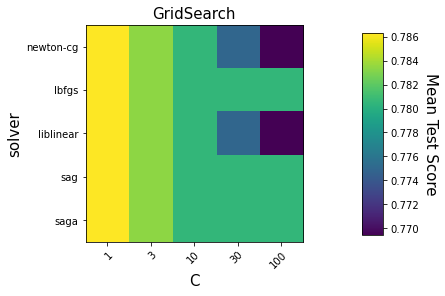

In [11]:
#make a heatmap of the results
def make_heatmap(ax, gs):
    """Helper to make a heatmap."""
    results = pd.DataFrame.from_dict(gs.cv_results_)
    results['params_str'] = results.params.apply(str)

    scores_matrix = results.pivot(index='param_logisticregression__solver', columns='param_logisticregression__C',
                                      values='mean_test_score')

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels([x for x in Cs])
    ax.set_xlabel('C', fontsize=15)

    ax.set_yticks(np.arange(len(solvers)))
    ax.set_yticklabels([x for x in solvers])
    ax.set_ylabel('solver', fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    cbar_ax.set_ylabel('Mean Test Score', rotation=-90, va="bottom",
                       fontsize=15)


fig, axes = plt.subplots(ncols=1, sharey=True)
ax2 = axes

make_heatmap(ax2, clf)


ax2.set_title('GridSearch', fontsize=15)

plt.show()

## Prediction Test

Create a logistic regression model, with test and training splits, and 10 cross validation folds for determing accuracy. 

Also, since the supplies column is so much larger than the rest of the variables, we're going to normalize the data set with the StandardScaler model which brings all the columns to a normal distribution by subtracting the mean and dividing by the standard deviation. 

In [12]:
#standard test, train split should be 20-30% held back for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#cross validation
cv = KFold(n_splits = 10, random_state=10, shuffle=True)


#create model
scaler = StandardScaler()
logreg = LogisticRegression(random_state=RANDOM_STATE,C=3, solver='lbfgs')

#simple pipeline of normalizing all the stats then applying logistic regression
pipe = make_pipeline(scaler, logreg)




pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.fit(X, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=3, random_state=42))])

10-fold cross validation accuracy: 0.761 (0.075 stdev)


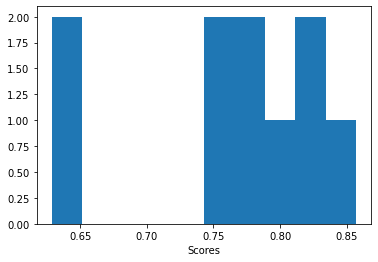

In [13]:
#score it
scores = cross_val_score(pipe, X, y, scoring = 'accuracy', cv=cv, n_jobs = -1)
print('10-fold cross validation accuracy: %.3f (%.3f stdev)' % (mean(scores), std(scores)))

plt.hist(scores)
plt.xlabel("Scores")
plt.show()

For this run, we got a 10-fold cross validation accuracy of 78%. This is normal for the process. 

## Relative importance of each feature

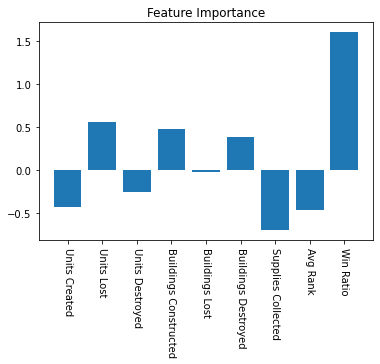

In [14]:
fig, ax = plt.subplots()
ax.bar(x = np.arange(len(pipe.steps[1][1].coef_[0])), height = -(pipe.steps[1][1].coef_[0]))
ax.set_xticks(np.arange(len(prediction_columns)))
ax.set_xticklabels(prediction_columns)
plt.xticks(rotation=-90)
plt.title('Feature Importance')
plt.show()

We can see that the model is rewarding the Win Ratio a lot, if the person has been winning a good deal recently, it will guess they continue to win. 

There's also some rewards for losing a lot of units but also destroying units, and less of a reward for creating a lot of units, and making a ton of supplies

## Example ranking

Let's see what the odds would be now for one team to play against some others, for instance, how likely is it that our best player, CoreDawg, is able to fend off two hard armies? 

In [15]:
#chances of one team possibilities

first_team=['Neo', 'Shift', 'Matt', 'Skippy'] 
second_team= ['Hard', 'Hard', 'Hard', 'Hard']
test_team = [first_team, second_team]


team_values = []

for team in range(2):
    #print('team ', team)
    names = []
    for name in test_team[team]:
        #"Make sure we're getting correct names input:
        if name not in games.Name.unique():
            print(name +' not found')
            break
        name_stats = games_copy.loc[(games_copy.Name==name)].tail(MAX_NUMBER_OF_GAMES).iloc[:,6:].mean()
        name_stats['Win Ratio'] = games_copy.loc[(games_copy.Name==name)&(games_copy.Game<=game),'Win'].tail(MAX_NUMBER_OF_GAMES).mean()
        name_stats['Avg Rank'] = games_copy.loc[(games_copy.Name==name)&(games_copy.Game<=game),'Normalized Rank'].tail(MAX_NUMBER_OF_GAMES).mean()
        names += [name_stats]
        names[-1].loc['Win_avg'] = games_copy.loc[(games_copy.Name==name)&
                                                  (~games_copy.Team.isna())&
                                                  (games_copy.Game<=game)].Win.fillna(0).tail(MAX_NUMBER_OF_GAMES).mean()

    team_values  += [pd.concat(names, axis = 1).T.sum()]
predicted_games =[team_values[1]-team_values[0]]
X_predict = pd.concat(predicted_games, axis = 1).T[prediction_columns]
predicted_win = pipe.predict(X_predict)[0]
probability = pipe.predict_proba(X_predict)[0][predicted_win]

print('Between '+ ', '.join(first_team)+' and ' + ', '.join(second_team)+ ',\nModel predicts ' + ', '.join(test_team[predicted_win]) + ' with a '+"{:.2%}".format(probability)+' chance')

Between Neo, Shift, Matt, Skippy and Hard, Hard, Hard, Hard,
Model predicts Neo, Shift, Matt, Skippy with a 83.50% chance


## Team Generator

What we're really interested in though, is making even teams given a list of contestants. 

We'll use the `combinations` function from `itertools` to generate all possible teams that take half the players. For 8 players, there's 70 different unique combinations. However, for each of those 70, there's another unique team uses the other four players. This means we have effectively 35 different ways we can organize the players into two teams. 


In [16]:
#all possibilities
all_names = ['Hard', 'Hard', 'Hard', 'Hard', 'Neo', 'Shift','Matt', 'pcap']

#how many combos are possible?
possible_combos = list(combinations(all_names,int(len(all_names)/2)))
non_parity_combos= int(len(possible_combos)/2)
possible_combos    

[('Hard', 'Hard', 'Hard', 'Hard'),
 ('Hard', 'Hard', 'Hard', 'Neo'),
 ('Hard', 'Hard', 'Hard', 'Shift'),
 ('Hard', 'Hard', 'Hard', 'Matt'),
 ('Hard', 'Hard', 'Hard', 'pcap'),
 ('Hard', 'Hard', 'Hard', 'Neo'),
 ('Hard', 'Hard', 'Hard', 'Shift'),
 ('Hard', 'Hard', 'Hard', 'Matt'),
 ('Hard', 'Hard', 'Hard', 'pcap'),
 ('Hard', 'Hard', 'Neo', 'Shift'),
 ('Hard', 'Hard', 'Neo', 'Matt'),
 ('Hard', 'Hard', 'Neo', 'pcap'),
 ('Hard', 'Hard', 'Shift', 'Matt'),
 ('Hard', 'Hard', 'Shift', 'pcap'),
 ('Hard', 'Hard', 'Matt', 'pcap'),
 ('Hard', 'Hard', 'Hard', 'Neo'),
 ('Hard', 'Hard', 'Hard', 'Shift'),
 ('Hard', 'Hard', 'Hard', 'Matt'),
 ('Hard', 'Hard', 'Hard', 'pcap'),
 ('Hard', 'Hard', 'Neo', 'Shift'),
 ('Hard', 'Hard', 'Neo', 'Matt'),
 ('Hard', 'Hard', 'Neo', 'pcap'),
 ('Hard', 'Hard', 'Shift', 'Matt'),
 ('Hard', 'Hard', 'Shift', 'pcap'),
 ('Hard', 'Hard', 'Matt', 'pcap'),
 ('Hard', 'Hard', 'Neo', 'Shift'),
 ('Hard', 'Hard', 'Neo', 'Matt'),
 ('Hard', 'Hard', 'Neo', 'pcap'),
 ('Hard', 'Hard', 'Shi

Now for each unique combination, we'll create the two teams, and give a score of which team is predicted to win. 

In [17]:
possibilities = []
for combo_index in range(non_parity_combos):
    #create the two teams for this unique combination
    first_team=list(possible_combos[combo_index])
    second_team= list(possible_combos[2*non_parity_combos-combo_index-1])
    test_team = [first_team, second_team]
    
    #holders for each team's stats
    team_values = []
    
    for team in range(2):
        #print('team ', team)
        names = []
        for name in test_team[team]:
            #each person's stats from the last N games
            names += [games.loc[games.Name==name].tail(MAX_NUMBER_OF_GAMES).iloc[:,6:].mean()]
            #except for Win average which requires some extra calculations for blank spots
            names[-1].loc['Win_avg'] = games.loc[(games.Name==name)&(~games.Team.isna())].Win.fillna(0).tail(MAX_NUMBER_OF_GAMES).mean()
        #combine each team member's stats into a table for that team
        team_values  += [pd.concat(names, axis = 1).T.sum()]
    predicted_game =[team_values[1]-team_values[0]]
    X_predict = pd.concat(predicted_game, axis = 1).T[prediction_columns]
    
    team_predicted_to_win = pipe.predict(X_predict)[0]
    probability_of_winning = pipe.predict_proba(X_predict)[0][team_predicted_to_win]
    possibilities +=[{"Team 1":first_team, "Team 2":second_team, "Predicted Team": team_predicted_to_win+1, "Probability": probability_of_winning}]
all_runs = pd.DataFrame(possibilities)
all_runs

,Team 1,Team 2,Predicted Team,Probability
0,"[Hard, Hard, Hard, Hard]","[Neo, Shift, Matt, pcap]",2,0.965438
1,"[Hard, Hard, Hard, Neo]","[Hard, Shift, Matt, pcap]",2,0.590536
2,"[Hard, Hard, Hard, Shift]","[Hard, Neo, Matt, pcap]",2,0.594433
3,"[Hard, Hard, Hard, Matt]","[Hard, Neo, Shift, pcap]",2,0.499961
4,"[Hard, Hard, Hard, pcap]","[Hard, Neo, Shift, Matt]",2,0.996667
5,"[Hard, Hard, Hard, Neo]","[Hard, Shift, Matt, pcap]",2,0.590536
6,"[Hard, Hard, Hard, Shift]","[Hard, Neo, Matt, pcap]",2,0.594433
7,"[Hard, Hard, Hard, Matt]","[Hard, Neo, Shift, pcap]",2,0.499961
8,"[Hard, Hard, Hard, pcap]","[Hard, Neo, Shift, Matt]",2,0.996667
9,"[Hard, Hard, Neo, Shift]","[Hard, Hard, Matt, pcap]",1,0.908797


This gives us all the possible matchups and which teams are predicted to win and by how much

All that's left is to rank the teams, smallest chance of winning to largest to get the most even teams. In other words, if the model has difficulty guessing which team would win, they're more evenly matched. 

In [18]:
desired_team_bool = all_runs.Probability == all_runs.Probability.min()
first_team  = all_runs.loc[desired_team_bool, 'Team 1'].values[0]
second_team = all_runs.loc[desired_team_bool, 'Team 2'].values[0]
team_predicted_to_win= all_runs.loc[desired_team_bool, 'Predicted Team'].values[0]-1

test_team = [first_team, second_team]
probability = all_runs.Probability.min()

print('\n\nFor '+ ', '.join(all_names)+',\nThe most even teams are '+ ', '.join(first_team)+' and ' + ', '.join(second_team)+ ',\nI predict ' + ', '.join(test_team[team_predicted_to_win]) + ' with a '+"{:.2%}".format(probability)+' chance')



For Hard, Hard, Hard, Hard, Neo, Shift, Matt, pcap,
The most even teams are Hard, Hard, Hard, Matt and Hard, Neo, Shift, pcap,
I predict Hard, Neo, Shift, pcap with a 50.00% chance


## Update the google sheet with the updated team maker stats 

This boils down to the model's rating of each person, they can just be added together for each team and google sheets or tableau can use that number to recreate the teams generated. Because logistic regression uses the sigmoid function so the probability will shift as more ratings are added or subtracted. This boils down to trying to find the team with the most even summation of their individual ratings. 

38 cells updated.


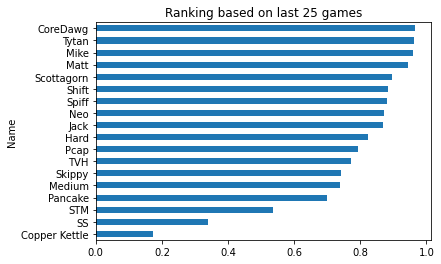

In [19]:
#Player rankings
names = []
stats= {}
sheets_stats = [['Name', 'Predictive Rating']]
for name in games.Name.unique():
    only_team=[name]
    predicted_games = []
    team_values = []
    for team in range(2):
        #print('team ', team)
        names = []
        for name in only_team:
            name_stats = games_copy.loc[(games_copy.Name==name)].tail(MAX_NUMBER_OF_GAMES).iloc[:,6:].median()
            name_stats['Win Ratio'] = games_copy.loc[(games_copy.Name==name),'Win'].tail(MAX_NUMBER_OF_GAMES).mean()
            name_stats['Avg Rank'] = games_copy.loc[(games_copy.Name==name),'Normalized Rank'].tail(MAX_NUMBER_OF_GAMES).mean()
            names += [name_stats]
            names[-1].loc['Win_avg'] = games_copy.loc[(games_copy.Name==name)&
                                                      (~games_copy.Team.isna())].Win.fillna(0).tail(MAX_NUMBER_OF_GAMES).mean()
        team_values  += [pd.concat(names, axis = 1).T.sum()]
    predicted_games +=[team_values[0]]
    X_predict = pd.concat(predicted_games, axis = 1).T[prediction_columns]
    #predicted_win = pipe.predict(X_predict)[0]
    probability = pipe.predict_proba(X_predict)[0][1] #the player should always be 1
    #stats[name] = -math.log((1 - probability)/probability)
    stats[name] = probability
    #sheets_stats +=[[name, -math.log((1 - probability)/probability)]]
    sheets_stats +=[[name, probability]]
    games.loc[games.Name==name, 'Predictive Rating'] = stats[name]

RANGE = "'Team Maker'!P1:Q"+str(len(sheets_stats))
push_sheet_data(SCOPES,SPREADSHEET_ID,RANGE, sheets_stats)    

#make a quick plot to ensure no one is getting a good deal
games.groupby('Name')['Predictive Rating'].max().sort_values().plot.barh()
plt.title('Ranking based on last '+str(MAX_NUMBER_OF_GAMES)+' games')
plt.show()

## Update Tableau spreadsheet

The tableau data source will have two tabs, one of all the indivdual games which is a copy and paste of our games dataframe. 

The other tab will be a pre-calculated list of possible combinations for a 4v4, 3v3, or 2v2 game in binary form. 
This gives the possible name combinations for both the google sheet and tableau to ensure they're hitting all the name combos, create the resulting team, and rank them.  

In [20]:
v2 = []
v3 = []
v4 = []

#Do 4v4 since it will be the longest column and we don't have to error check the other two for rows with no names and ratings
for i in range(256):
    if i == 0:
        sheets_stats[0]+=['4v4']    
    number = bin(i+1).replace('0b',"")
    if (sum([int(x) for x in number])==4) & (len(number)==8):
        v4 +=[number]
        try:
            sheets_stats[len(v4)]+=[number]
        except:
            sheets_stats+=[["", "", number]]
for i in range(64):
    if i == 0:
        sheets_stats[0]+=['3v3']    
    number = bin(i+1).replace('0b',"")
    if (sum([int(x) for x in number])==3) & (len(number)==6):
        v3 +=[number]
        sheets_stats[len(v3)]+=[number]
for i in range(16):
    if i == 0:
        sheets_stats[0]+=['2v2']
    number = bin(i+1).replace('0b',"")
    if (sum([int(x) for x in number])==2) & (len(number)==4):
        v2 +=[number]
        sheets_stats[len(v2)]+=[number]
        
pd.DataFrame(sheets_stats[1:], columns=sheets_stats[0])

,Name,Predictive Rating,4v4,3v3,2v2
0,Matt,0.945633,10000111,100011,1001
1,Skippy,0.74034,10001011,100101,1010
2,Neo,0.872259,10001101,100110,1100
3,TVH,0.772892,10001110,101001,None
4,Pancake,0.698927,10010011,101010,None
5,Jack,0.868168,10010101,101100,None
6,Scottagorn,0.894642,10010110,110001,None
7,SS,0.339708,10011001,110010,None
8,STM,0.536517,10011010,110100,None
9,CoreDawg,0.964444,10011100,111000,None


## Save the data source

In [21]:
        
games.to_excel('Generals Statistics.xlsx',sheet_name="Games")

from openpyxl import load_workbook
workbook = load_workbook(filename="Generals Statistics.xlsx")
workbook.create_sheet('Teams')
sheet = workbook['Teams']
for i, rows in enumerate(sheets_stats):
    sheet.cell(row=i+1, column=1).value = rows[0]
    sheet.cell(row=i+1, column=2).value = rows[1]
    try:
        sheet.cell(row=i+1, column=3).value = rows[2]
    except:
        pass
    try:
        sheet.cell(row=i+1, column=4).value = rows[3]
    except:
        pass
    try:
        sheet.cell(row=i+1, column=5).value = rows[4]
    except:
        pass

#add a final name of 'None' with a value of 0 so it tableau doesn't have to have eight people every time
sheet.cell(row=len(games.Name.unique())+1, column=1).value = 'None'
sheet.cell(row=len(games.Name.unique())+1, column=2).value = 0
workbook.save(filename="Generals Statistics.xlsx")   

 

## Conclusion

This was a great project for taking each person's individual stats, creating some synthetic games based on them, and having a logistic regression model predict which team would win. With an ~80% accuracy rate, this could probably be improved with some more complex models but they'd be a lot less explainable as well as implementable inside of tableau and google sheets. Making this usable to the other team members when I'm not around was therefore more important than an extremely accurate model. 

If you'd like to see the tableau page of the latest stats, they can be found [here](https://public.tableau.com/app/profile/robert.piazza/viz/Generals/Overall) but I've also attempted to embed it below. 